Discard: Random test codes

# Bump hunting

## Task

- Regression of background and signal parameters and comparison with ground truth
  - Ground truth from Multinest
- Estimate of Bayesian evidence for a signal peak and comparison with ground truth
  - Ground truth from Multinest
  - TODO: implementation of model discrimination with swyft - requires essentially discrete variables
- Ability to do injection tests
  - Frequentist upper limits
  - Proper Bayesian posteriors
- Resilience against extra complications - randomly swapping cables

	
Authors
Tag
Arxiv-Pdf
Arxiv-Url
## Imports

In [6]:
# Makes it easier to debug
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import numpy as np
import pylab as plt
from scipy.linalg import inv
from scipy import stats
import torch

In [8]:
import dynesty
import swyft

## Workflow: ZoomTask

In [9]:
class ZoomTask:
    def __init__(self, sim_or_store, prior, target_obs, partition = None, simhook = None, init_bound = None):
        if not isinstance(sim_or_store, swyft.Simulator):
            self.store = sim_or_store
        else:
            self.store = swyft.MemoryStore(sim)
        
        if partition is None:
            self.partition = list(range(len(self.store.pnames)))
        else:
            self.partition = partition
            
        self.prior = prior
        self.simhook = simhook
        self.target_obs = target_obs
        
        self.init_bound = init_bound
        self.last_bound = None
        self.history = []
        
    def run(self, rounds = 10, N = 10000, train_args = {}, head = None):
        for i in range(rounds):
            self.round(N = N, train_args = train_args, head = head)
        
    def round(self, N, train_args = {}, head = None):
        bound = self.init_bound if self.history == [] else self.history[-1][1]
        
        self.store.add(N, self.prior, bound = bound)
        self.store.simulate()
        dataset = swyft.Dataset(N, self.prior, self.store, simhook = self.simhook, bound = bound)
        post = swyft.Posteriors(dataset)
        post.add(self.partition, device='cuda', head = head, tail_args = dict(p=0.2, hidden_layers = [512, 512]))
        post.train(self.partition, **train_args)
        bound = post.truncate(self.partition, self.target_obs)
        
        self.history.append([post, bound])

## Model

In [10]:
COUNTER = 0  # Counter for number of likelihood evaluations (relevant for Dynesty)

In [11]:
N = 64  # Number of data bins
SIGMA = 1.0  # Measurement uncertainty

In [12]:
# Noise-free model

# Model and reference parameters
def spec(a, b, c, d, LW = 0.3):
    global COUNTER
    COUNTER += 1
    x = np.linspace(0, 10, N)
    y_bg = a+x*b
    y_sig = c*stats.norm.pdf(x, d, LW)
    return y_bg + y_sig

def model(v):
    y = spec(v[0], v[1], v[2], v[3])
    noise = 0*np.random.randn(N)*SIGMA
    return dict(y=y + noise)

# Noise model
def noise(sim, v, sigma = SIGMA):
    #return sim
    noise = np.random.randn(N)*sigma
    return dict(y = sim['y'] + noise)

## Step 1 - Fast slow - Wide

In [436]:
# Prior
def transform(u):
    a = scipy.stats.uniform(-10., 20.).ppf(u[0])
    b = scipy.stats.uniform(-10., 20.).ppf(u[1])
    return np.array([a, b, 0, 0])

sigma_A = SIGMA/N**0.5  # Expected uncertainty

In [437]:
v0 = np.array([-0.0, 0, 0, 0])
obs0 = noise(model(v0), v0)

In [438]:
sim = swyft.Simulator(model, 4, dict(y=(N,)))
prior = swyft.Prior(transform, 4)

In [439]:
class Head(swyft.Module):
    def __init__(self, sim_shapes):
        super().__init__(sim_shapes=sim_shapes)
        self.n_features = 2
        
        self.onl_f = swyft.OnlineNormalizationLayer(torch.Size([N,]))
        self.l = torch.nn.Linear(N, 2)

    def forward(self, obs):
        x=obs['y']
        #x = self.onl_f(x)
        f = self.l(x)

        return f

In [496]:
%%time
task = ZoomTask(sim, prior, obs0, simhook = noise, partition = [0, 1])
task.run(rounds = 1, N = 1000, train_args = dict(batch_size = 128, max_epochs = 100, scheduler_args = dict(factor=0.5, patience = 1), early_stopping_patience = 10),
         head = Head)

Creating new store.
Store: Adding 955 new samples to simulator store.
Training: lr=7.8e-06, Epoch=31, VL=0.9278
Bounds: Truncating...
Bounds: ...done. New volue is V=0.7473
CPU times: user 4.75 s, sys: 6.1 s, total: 10.9 s
Wall time: 16.9 s


In [497]:
post = task.history[-1][0]
samples = post.sample(1000000, obs0)

In [498]:
# Estimate poster mean
v = samples['v'][:,0]
w = samples['weights'][(0,)]
m = sum(w*v)/sum(w)
#m = -0.5

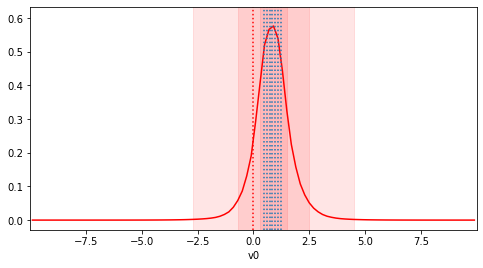

In [499]:
fig, diag = swyft.plot_1d(samples, [0], bins = 100, figsize=(8, 4), truth = v0, color='r', contours = True)
for s in [-3, -2, -1, 0, 1, 2, 3]:
    fig.get_axes()[0].axvline(m + s*sigma_A, ls = ':')

Text(0, 0.5, 'feature 2')

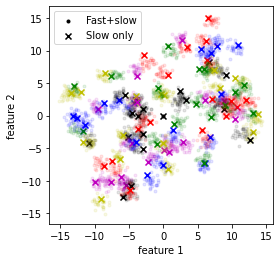

In [553]:
h = task.history[-1][0]._ratios[((0,),(1,))].head
d = task.history[-1][0].dataset
h.cpu()

import cycler
color_cycle = cycler.cycler(color=['r', 'k', 'b', 'y', 'm', 'g'])

plt.figure(figsize = (4,4))

for i, c in zip(range(100), color_cycle()):
    s = np.array([h(d[i][0]).detach().numpy() for _ in range(30)])
    plt.scatter(s[:,0], s[:,1], marker='.', alpha = 0.1, color=c['color'])
    plt.scatter(s[0,0], s[0,1], marker='x', color=c['color'])

plt.scatter(0, 0, marker='.', color='k', label='Fast+slow')
plt.scatter(0, 0, marker='x', color='k', label='Slow only')
plt.legend(frameon = True)
    
plt.xlabel("feature 1")
plt.ylabel("feature 2")

## Step 1 - Fast slow - Narrow

In [555]:
# Prior
def transform(u):
    a = scipy.stats.uniform(-1., 2.).ppf(u[0])
    b = scipy.stats.uniform(-1., 2.).ppf(u[1])
    return np.array([a, b, 0, 0])

sigma_A = SIGMA/N**0.5  # Expected uncertainty

In [556]:
v0 = np.array([-0.0, 0, 0, 0])
obs0 = noise(model(v0), v0)

In [557]:
sim = swyft.Simulator(model, 4, dict(y=(N,)))
prior = swyft.Prior(transform, 4)

In [558]:
class Head(swyft.Module):
    def __init__(self, sim_shapes):
        super().__init__(sim_shapes=sim_shapes)
        self.n_features = 2
        
        self.onl_f = swyft.OnlineNormalizationLayer(torch.Size([N,]))
        self.l = torch.nn.Linear(N, 2)

    def forward(self, obs):
        x=obs['y']
        #x = self.onl_f(x)
        f = self.l(x)

        return f

In [559]:
%%time
task = ZoomTask(sim, prior, obs0, simhook = noise, partition = [0, 1])
task.run(rounds = 1, N = 1000, train_args = dict(batch_size = 128, max_epochs = 100, scheduler_args = dict(factor=0.5, patience = 1), early_stopping_patience = 10),
         head = Head)

Creating new store.
Store: Adding 984 new samples to simulator store.
Training: lr=2.4e-07, Epoch=45, VL=1.666
Bounds: Truncating...
Bounds: ...done. New volue is V=0.8797
CPU times: user 5.88 s, sys: 8.84 s, total: 14.7 s
Wall time: 23.3 s


In [560]:
post = task.history[-1][0]
samples = post.sample(1000000, obs0)

In [561]:
# Estimate poster mean
v = samples['v'][:,0]
w = samples['weights'][(0,)]
m = sum(w*v)/sum(w)
#m = -0.5

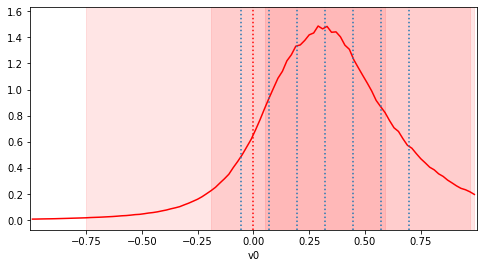

In [562]:
fig, diag = swyft.plot_1d(samples, [0], bins = 100, figsize=(8, 4), truth = v0, color='r', contours = True)
for s in [-3, -2, -1, 0, 1, 2, 3]:
    fig.get_axes()[0].axvline(m + s*sigma_A, ls = ':')

Text(0, 0.5, 'feature 2')

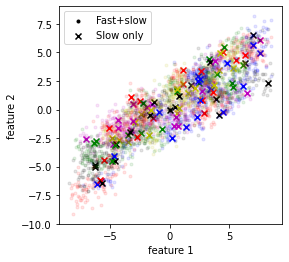

In [563]:
h = task.history[-1][0]._ratios[((0,),(1,))].head
d = task.history[-1][0].dataset
h.cpu()

import cycler
color_cycle = cycler.cycler(color=['r', 'k', 'b', 'y', 'm', 'g'])

plt.figure(figsize = (4,4))

for i, c in zip(range(100), color_cycle()):
    s = np.array([h(d[i][0]).detach().numpy() for _ in range(30)])
    plt.scatter(s[:,0], s[:,1], marker='.', alpha = 0.1, color=c['color'])
    plt.scatter(s[0,0], s[0,1], marker='x', color=c['color'])

plt.scatter(0, 0, marker='.', color='k', label='Fast+slow')
plt.scatter(0, 0, marker='x', color='k', label='Slow only')
plt.legend(frameon = True)
    
plt.xlabel("feature 1")
plt.ylabel("feature 2")

Text(0, 0.5, 'x[i]')

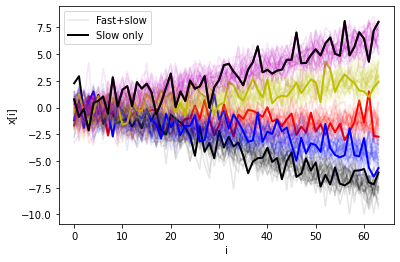

In [585]:
d = task.history[-1][0].dataset
for i, c in zip(range(5), color_cycle()):
    for _ in range(30):
        y = d[i][0]['y']
        plt.plot(y, color=c['color'], alpha = 0.1)
    plt.plot(y, color=c['color'], lw=2)

plt.plot(y, color='k', label='Fast+slow', alpha=0.1)
plt.plot(y, color='k', label='Slow only', lw=2)
plt.legend(frameon = True)
    
plt.xlabel("i")
plt.ylabel("x[i]")

## Step 1 - Anchors

In [13]:
# Prior
def transform(u):
    a = scipy.stats.uniform(-1., 2.).ppf(u[0])
    return np.array([a, 0, 0, 0])

sigma_A = SIGMA/N**0.5  # Expected uncertainty

In [425]:
v0 = np.array([-0.0, 0, 0, 0])
obs0 = noise(model(v0), v0)

In [426]:
sim = swyft.Simulator(model, 4, dict(y=(N,)))
prior = swyft.Prior(transform, 4)

In [427]:
class Head(swyft.Module):
    def __init__(self, sim_shapes):
        super().__init__(sim_shapes=sim_shapes)
        self.n_features = 1
        
        self.onl_f = swyft.OnlineNormalizationLayer(torch.Size([N,]))
        self.l = torch.nn.Linear(N, 1)

    def forward(self, obs):
        x=obs['y']
        #x = self.onl_f(x)
        f = self.l(x)

        return f

In [428]:
%%time
task = ZoomTask(sim, prior, obs0, simhook = noise, partition = [0])
task.run(rounds = 1, N = 10000, train_args = dict(batch_size = 128, max_epochs = 100, scheduler_args = dict(factor=0.5, patience = 1), early_stopping_patience = 10),
         head = Head)

Creating new store.
Store: Adding 10003 new samples to simulator store.
Training: lr=3.9e-06, Epoch=23, VL=0.6479
Bounds: Truncating...
Bounds: ...done. New volue is V=0.8164
CPU times: user 25 s, sys: 6.18 s, total: 31.1 s
Wall time: 54.9 s


In [429]:
post = task.history[-1][0]
samples = post.sample(1000000, obs0)

In [430]:
# Estimate poster mean
v = samples['v'][:,0]
w = samples['weights'][(0,)]
m = sum(w*v)/sum(w)
#m = -0.5

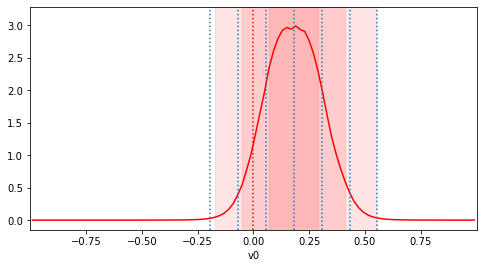

In [431]:
fig, diag = swyft.plot_1d(samples, [0], bins = 100, figsize=(8, 4), truth = v0, color='r', contours = True)
for s in [-3, -2, -1, 0, 1, 2, 3]:
    fig.get_axes()[0].axvline(m + s*sigma_A, ls = ':')

## Prior

In [97]:
def transform(u):
    a = scipy.stats.uniform(-2.5, 5).ppf(u[0])
    b = scipy.stats.uniform(-1, 2).ppf(u[1])
    c = scipy.stats.uniform(0., 10.).ppf(u[2])
    d = scipy.stats.uniform(0., 10.).ppf(u[3])
    return np.array([a, b, c, d])

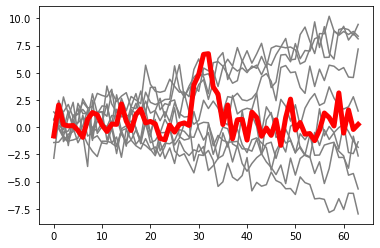

In [730]:
v0 = np.array([0, 0, 5, 5])

for _ in range(10):
    u = np.random.rand(4)
    v = transform(u)
    obs = noise(model(v), v)
    plt.plot(obs['y'], color='0.5')

obs0 = noise(model(v0), v0)
plt.plot(obs0['y'], linewidth = 5, color = 'r')

## Factorization plot

In [751]:
cov = np.eye(6)
cov[1, 0]= 0.9
cov[3, 2]= -0.7
cov[4, 3]= 0.7
cov[4, 2]= -0.5
cov[5, 4]= -0.7
mn = scipy.stats.multivariate_normal(np.zeros(6), cov)

In [752]:
v = np.random.rand(10000000, 6)*6  -3
weights = {(0, 1, 2, 3, 4, 5) : mn.pdf(v)}

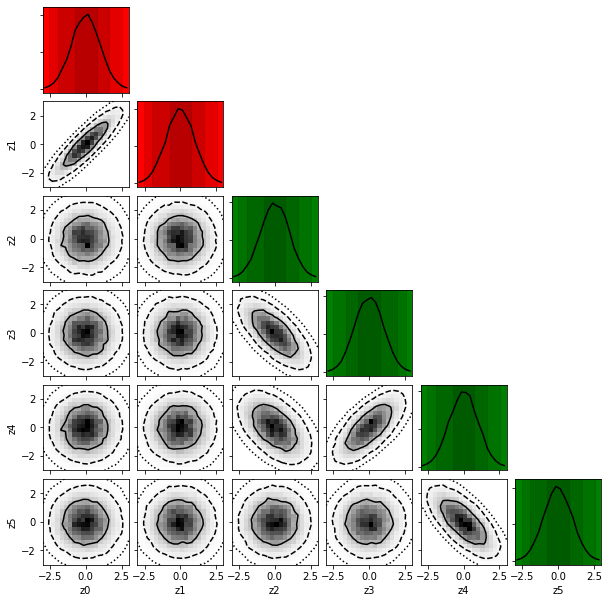

In [753]:
s = dict(v=v, weights = weights, pnames = ['z0', 'z1', 'z2', 'z3', 'z4', 'z5'])
fig, _ = swyft.plot_corner(s, [0, 1, 2, 3, 4, 5], bins = 20)
fig.get_axes()[0].set_facecolor('r')
fig.get_axes()[7].set_facecolor('r')
fig.get_axes()[14].set_facecolor('g')
fig.get_axes()[21].set_facecolor('g')
fig.get_axes()[28].set_facecolor('g')
fig.get_axes()[35].set_facecolor('g')

## Dynesty analysis

In [110]:
def loglike(v):    
    mu = model(v)['y']
    return -0.5*sum((obs0['y'] - mu)**2)

In [111]:
ns = dynesty.NestedSampler(loglike, transform, 4)
ns.run_nested()
print(COUNTER)

64it [00:00, 306.48it/s, bound: 0 | nc: 1 | ncall: 566 | eff(%): 11.307 | loglstar:   -inf < -1276.838 <    inf | logz: -1283.874 +/-  0.168 | dlogz: 1238.823 >  0.509]

2 0.002


1793it [00:53,  8.93it/s, bound: 1 | nc: 3 | ncall: 17989 | eff(%):  9.967 | loglstar:   -inf < -122.894 <    inf | logz: -129.840 +/-  0.153 | dlogz: 91.639 >  0.509]  

3 5.5727942845850605e-05


2087it [00:56, 76.10it/s, bound: 2 | nc: 1 | ncall: 18756 | eff(%): 11.127 | loglstar:   -inf < -109.718 <    inf | logz: -116.700 +/-  0.156 | dlogz: 79.885 >  0.509] 

3 3.140775772937678e-05


2315it [00:59, 78.46it/s, bound: 3 | nc: 1 | ncall: 19499 | eff(%): 11.872 | loglstar:   -inf < -100.540 <    inf | logz: -108.240 +/-  0.161 | dlogz: 76.879 >  0.509] 

3 1.9915738862627373e-05


2590it [01:02, 87.87it/s, bound: 4 | nc: 1 | ncall: 20284 | eff(%): 12.769 | loglstar:   -inf < -84.165 <    inf | logz: -92.624 +/-  0.173 | dlogz: 60.724 >  0.509]   

3 1.1658617465247599e-05


2837it [01:04, 82.79it/s, bound: 5 | nc: 2 | ncall: 21024 | eff(%): 13.494 | loglstar:   -inf < -72.036 <    inf | logz: -80.728 +/-  0.176 | dlogz: 48.321 >  0.509] 

3 7.060719332901589e-06


3083it [01:07, 94.37it/s, bound: 6 | nc: 7 | ncall: 21783 | eff(%): 14.153 | loglstar:   -inf < -62.103 <    inf | logz: -71.172 +/-  0.178 | dlogz: 38.271 >  0.509] 

3 4.345028368949183e-06


3364it [01:09, 133.87it/s, bound: 7 | nc: 2 | ncall: 22530 | eff(%): 14.931 | loglstar:   -inf < -53.626 <    inf | logz: -62.735 +/-  0.180 | dlogz: 29.257 >  0.509]

3 2.5182836063909855e-06


3690it [01:12, 137.26it/s, bound: 8 | nc: 1 | ncall: 23291 | eff(%): 15.843 | loglstar:   -inf < -46.185 <    inf | logz: -55.817 +/-  0.184 | dlogz: 21.685 >  0.509]

3 1.334041043362508e-06


4020it [01:14, 136.17it/s, bound: 9 | nc: 1 | ncall: 24055 | eff(%): 16.712 | loglstar:   -inf < -40.699 <    inf | logz: -50.612 +/-  0.188 | dlogz: 15.815 >  0.509]

3 6.913354190889784e-07


4347it [01:16, 132.84it/s, bound: 10 | nc: 1 | ncall: 24802 | eff(%): 17.527 | loglstar:   -inf < -36.515 <    inf | logz: -46.828 +/-  0.191 | dlogz: 11.375 >  0.509]

3 3.5826833369563124e-07


4665it [01:19, 149.70it/s, bound: 11 | nc: 1 | ncall: 25542 | eff(%): 18.264 | loglstar:   -inf < -33.854 <    inf | logz: -44.378 +/-  0.194 | dlogz:  8.457 >  0.509] 

3 1.8903295955713733e-07


5047it [01:21, 152.27it/s, bound: 12 | nc: 2 | ncall: 26301 | eff(%): 19.189 | loglstar:   -inf < -31.454 <    inf | logz: -42.295 +/-  0.197 | dlogz:  5.684 >  0.509]

3 8.900338344267557e-08


5398it [01:24, 140.57it/s, bound: 13 | nc: 1 | ncall: 27059 | eff(%): 19.949 | loglstar:   -inf < -29.931 <    inf | logz: -41.071 +/-  0.199 | dlogz:  3.832 >  0.509]

3 4.370163157898217e-08


5734it [01:26, 147.67it/s, bound: 14 | nc: 3 | ncall: 27799 | eff(%): 20.627 | loglstar:   -inf < -28.876 <    inf | logz: -40.281 +/-  0.201 | dlogz:  2.575 >  0.509]

3 2.2288225621452946e-08


6064it [01:29, 122.51it/s, bound: 15 | nc: 1 | ncall: 28545 | eff(%): 21.244 | loglstar:   -inf < -28.125 <    inf | logz: -39.772 +/-  0.203 | dlogz:  1.562 >  0.509]

3 1.1344506750231744e-08


6420it [01:31, 155.58it/s, bound: 16 | nc: 2 | ncall: 29318 | eff(%): 21.898 | loglstar:   -inf < -27.591 <    inf | logz: -39.426 +/-  0.204 | dlogz:  0.836 >  0.509] 

3 5.7397447002447554e-09


6679it [01:33, 71.60it/s, +500 | bound: 16 | nc: 1 | ncall: 29842 | eff(%): 24.057 | loglstar:   -inf < -26.333 <    inf | logz: -38.958 +/-  0.223 | dlogz:  0.001 >  0.509]

30504


In [112]:
s = ns.results.samples
w = ns.results.logwt
w -= w.max()
w = np.exp(w)
samples_MN = dict(v = s[w>0], weights = {(0, 1, 2, 3): w[w>0]}, pnames = ['bg_offste', 'bg_slope', 'sig_norm', 'sig_pos'])

## SWYFT

### Zoom in

In [58]:
sim = swyft.Simulator(model, ['bg_offset', 'bg_slope', 'sig_norm', 'sig_pos'], dict(y=(N,)))
prior = swyft.Prior(transform, 4)

In [60]:
class Head(swyft.Module):
    def __init__(self, sim_shapes):
        super().__init__(sim_shapes=sim_shapes)
        self.n_features = 4
        
        self.onl_f = swyft.OnlineNormalizationLayer(torch.Size([N,]))
        self.l = torch.nn.Linear(N, 4)

    def forward(self, obs):
        x=obs['y']
        #x = self.onl_f(x)
        f = self.l(x)

        return f

In [ ]:
%%time
task = ZoomTask(sim, prior, obs0, simhook = noise, partition = [[0], [1], [2], [3]])
task.run(rounds = 3, N = 3000, train_args = dict(batch_size = 128, max_epochs = 30), head = Head)
task.run(rounds = 1, N = 10000, train_args = dict(batch_size = 128, max_epochs = 30), head = Head)

Creating new store.
Store: Adding 3002 new samples to simulator store.
Training: lr=0.001, Epoch=23, VL=3.179
Bounds: Truncating...
Bounds: ...done. New volue is V=0.144
Store: Adding 2590 new samples to simulator store.
Training: lr=0.001, Epoch=30, VL=2.427
Bounds: Truncating...
Bounds: ...done. New volue is V=0.02184
Store: Adding 2612 new samples to simulator store.
Training: lr=0.001, Epoch=30, VL=3.697
Bounds: Truncating...
Bounds: ...done. New volue is V=0.02175
Store: Adding 7162 new samples to simulator store.
Training: lr=0.001, Epoch=15, VL=2.686

In [25]:
print([h[1].volume for h in task.history])

[0.07804163245138508, 0.005426712431398363, 0.0009544284249515855, 0.0003164095292910167]


In [53]:
post = task.history[-1][0]
samples = post.sample(100000, obs0)

/home/weniger/swyft/swyft/utils/plot.py:128: RuntimeWarning: divide by zero encountered in log
  entropy = -simps(v * np.log(v), zm)
/home/weniger/swyft/swyft/utils/plot.py:128: RuntimeWarning: invalid value encountered in multiply
  entropy = -simps(v * np.log(v), zm)
/home/weniger/swyft/swyft/utils/plot.py:128: RuntimeWarning: divide by zero encountered in log
  entropy = -simps(v * np.log(v), zm)
/home/weniger/swyft/swyft/utils/plot.py:128: RuntimeWarning: invalid value encountered in multiply
  entropy = -simps(v * np.log(v), zm)
/home/weniger/swyft/swyft/utils/plot.py:128: RuntimeWarning: divide by zero encountered in log
  entropy = -simps(v * np.log(v), zm)
/home/weniger/swyft/swyft/utils/plot.py:128: RuntimeWarning: invalid value encountered in multiply
  entropy = -simps(v * np.log(v), zm)


(2.0, 4.0)

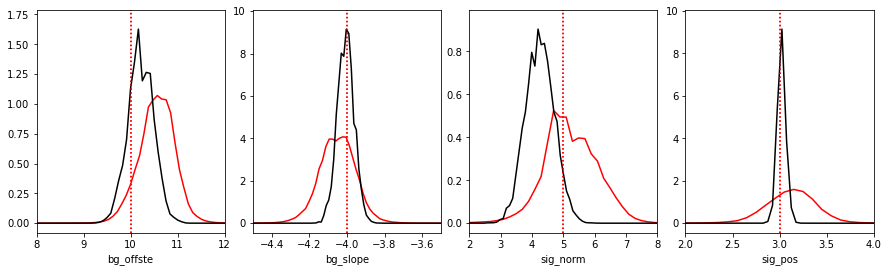

In [57]:
fig, diag = swyft.plot_1d(samples, [0, 1, 2, 3], bins = 100, figsize=(15,4), truth = v0, color='r', contours = False)
swyft.plot_1d(samples_MN, [0, 1, 2, 3], bins = 200, figsize=(15,4), truth = v0, fig = fig, contours = False)
fig.get_axes()[0].set_xlim([8, 12])
fig.get_axes()[1].set_xlim([-4.5, -3.5])
fig.get_axes()[2].set_xlim([2., 8])
fig.get_axes()[3].set_xlim([2.0, 4.])

### 2-dim posteriors

In [16]:
bound = task.history[-1][1]
store = task.store
store.add(10000, prior, bound = bound)
dataset = swyft.Dataset(10000, prior, store, simhook = noise, bound = bound)
task.store.simulate()

Store: Adding 8884 new samples to simulator store.


In [17]:
post = swyft.Posteriors(dataset)
post.add([[0, 1], [1, 2]], device='cuda')
post.train([[0, 1], [1, 2]])

Training: lr=0.001, Epoch=17, VL=0.7364


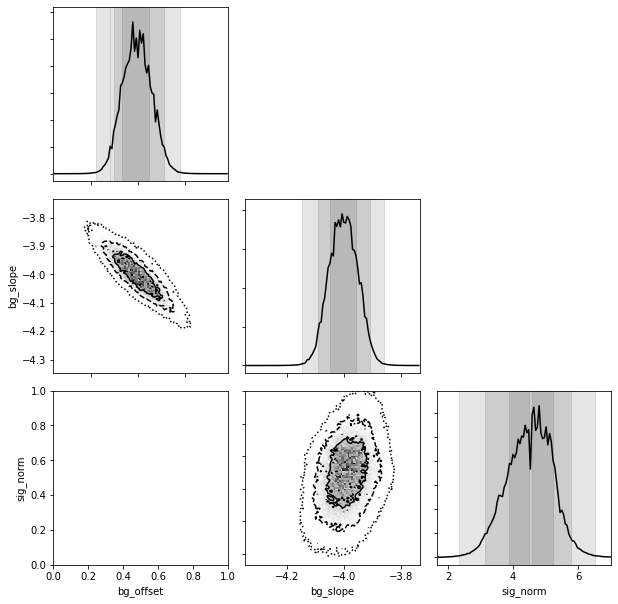

In [18]:
samples = post.sample(100000, obs0)
swyft.plot_corner(samples, [0, 1, 2]);

### Empirical vs nominal mass

In [19]:
masses = post.empirical_mass(nobs = 1000)

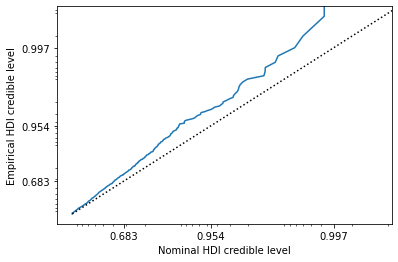

In [20]:
swyft.plot_empirical_mass(masses[(1, 2)])

## Frequentist upper limits

In [21]:
# Prior is defined in terms of a transform function

def transform2(u):
    return u*np.array([20, 10, 100, 0.0001]) + np.array([0, -5, 0, 5])
prior = swyft.Prior(transform2, 4)

In [22]:
%%time
task = ZoomTask(sim, prior, obs0, simhook = noise, partition = [0, 1])
task.run(rounds = 3, N = 3000, train_args = dict(batch_size = 128, max_epochs = 100))

Creating new store.
Store: Adding 2985 new samples to simulator store.
Training: lr=0.001, Epoch=35, VL=0.7959
Bounds: Truncating...
Bounds: ...done. New volue is V=0.05873
Store: Adding 2835 new samples to simulator store.
Training: lr=0.001, Epoch=29, VL=0.9128
Bounds: Truncating...
Bounds: ...done. New volue is V=0.01278
Store: Adding 2400 new samples to simulator store.
Training: lr=0.001, Epoch=13, VL=1.376
Bounds: Truncating...
Bounds: ...done. New volue is V=0.01016
CPU times: user 28.3 s, sys: 11.9 s, total: 40.2 s
Wall time: 1min 12s


In [23]:
post = task.history[-1][0]
bound = task.history[-1][1]

In [24]:
post2 = swyft.Posteriors(post.dataset)
post2.add([2])
post2.train([2])

Training: lr=0.001, Epoch=28, VL=0.1922


In [93]:
TS = []
g = 3.
grid = np.linspace(0, 30, 100)
for _ in range(1000):
    v = prior.v(bound.sample(1))
    v[0, 2] = g
    obs = noise(model(v[0]), v[0])
    v = np.repeat(v, 101, axis = 0)
    v[:len(grid),2] = grid
    v[-1, 2] = g
    t = post2.eval(v, obs)['weights'][(2,)]
    tmax = t.max()
    t /= tmax
    t = -2*np.log(t)
    TS.append(t[-1])
TS = np.array(TS)

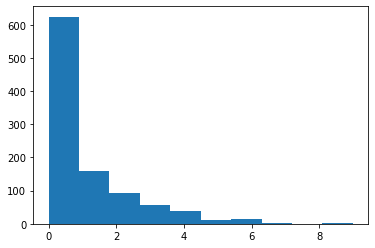

In [94]:
plt.hist(TS, bins = 10);

In [95]:
np.quantile(TS, [0.05, 0.95])

array([-0.       ,  3.8696094])